In [ ]:
#importing necssary packages
import numpy as np
import pandas as pd
from cytoolz import *
from tqdm.auto import tqdm

tqdm.pandas()

In [ ]:
#Utilizing the split dataset for our model to train and to test
train = pd.read_parquet(
    "s3://ling583/wine-train.parquet", storage_options={"anon": True}
)
test = pd.read_parquet("s3://ling583/wine-test.parquet", storage_options={"anon": True})

In [ ]:
train.head()

,review_text,wine_variant
0,Rich smoky dark cherry nose very intense fruit...,Pinot Noir
1,Had this at Corton Restaurant in NYC. First of...,Syrah
2,"Nose is very tart, with a layer of sweet fruit...",Pinot Noir
3,Beautiful golden color. Discrete perfumed nose...,Chardonnay
4,Please take the time to decant: you will not b...,Pinot Noir


In [ ]:
#importing spacy and defining our teokinzer
import spacy

nlp = spacy.load(
    "en_core_web_sm",
    exclude=["tagger", "parser", "ner", "lemmatizer", "attribute_ruler"],
)


def tokenize(text):
    doc = nlp.tokenizer(text)
    return [t.norm_ for t in doc if not (t.is_space or t.is_punct or t.like_num)]

In [ ]:
import multiprocessing as mp

In [ ]:
#tokenizing our train and test datasets
with mp.Pool() as p:
    train["tokens"] = pd.Series(p.imap(tokenize, tqdm(train["review_text"]), chunksize=50))
    test["tokens"] = pd.Series(p.imap(tokenize, tqdm(test["review_text"]), chunksize=50))

  0%|          | 0/130497 [00:00<?, ?it/s]

  0%|          | 0/32625 [00:00<?, ?it/s]

In [ ]:
#looking at our categories
train["wine_variant"].value_counts()

Pinot Noir            38471
Cabernet Sauvignon    30234
Chardonnay            19443
Syrah                 13704
Riesling               9683
Zinfandel              8327
Merlot                 5522
Sauvignon Blanc        5113
Name: wine_variant, dtype: int64

In [ ]:
#importing necessary sklearn tools needed to conduct analysis
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.pipeline import make_pipeline

In [ ]:
#establishing our baseline to determine a threshold to try to beat for our sgdclassifier
baseline = make_pipeline(CountVectorizer(analyzer=identity), SGDClassifier())
baseline.fit(train["tokens"], train["wine_variant"])
base_predicted = baseline.predict(test["tokens"])
print(classification_report(test["wine_variant"], base_predicted))

                    precision    recall  f1-score   support

Cabernet Sauvignon       0.66      0.85      0.74      7558
        Chardonnay       0.88      0.79      0.83      4861
            Merlot       0.64      0.35      0.45      1381
        Pinot Noir       0.78      0.85      0.82      9618
          Riesling       0.75      0.83      0.79      2421
   Sauvignon Blanc       0.83      0.67      0.74      1278
             Syrah       0.77      0.51      0.62      3426
         Zinfandel       0.79      0.55      0.65      2082

          accuracy                           0.76     32625
         macro avg       0.76      0.67      0.70     32625
      weighted avg       0.76      0.76      0.75     32625



In [ ]:
#storing our model results to mlflow and visually see how our model did
import mlflow
from dask_ml.model_selection import RandomizedSearchCV
from logger import log_search
from scipy.stats.distributions import loguniform, randint, uniform

In [ ]:
from warnings import simplefilter

simplefilter(action="ignore", category=FutureWarning)

In [ ]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:39691")
client

Client Scheduler: tcp://127.0.0.1:39691 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 16.62 GB


In [ ]:
#created a pipeline for sgdclassifier
mlflow.set_experiment("project-2")
sgd = make_pipeline(
    CountVectorizer(analyzer=identity), TfidfTransformer(), SGDClassifier()
)

In [ ]:
%%time

search = RandomizedSearchCV(
    sgd,
    {
        "countvectorizer__min_df": randint(1, 20),
        "countvectorizer__max_df": uniform(0.5, 0.5),
        "tfidftransformer__use_idf": [True, False],
        "sgdclassifier__alpha": loguniform(1e-6, 1e-2),
        
    },
    n_iter=50,
    scoring="f1_macro",
)
search.fit(train["tokens"], train["wine_variant"])
log_search(search)

CPU times: user 11.7 s, sys: 1.53 s, total: 13.2 s
Wall time: 7min 16s


In [ ]:
%%time

search = RandomizedSearchCV(
    sgd,
    {
        "countvectorizer__min_df": randint(1, 20),
        "countvectorizer__max_df": uniform(0.5, 0.5),
        "tfidftransformer__use_idf": [True, False],
        "sgdclassifier__alpha": [1.028e-05],
        
    },
    n_iter=50,
    scoring="f1_macro",
)
search.fit(train["tokens"], train["wine_variant"])
log_search(search)

CPU times: user 11.5 s, sys: 1.56 s, total: 13 s
Wall time: 7min 33s


In [ ]:
%%time

search = RandomizedSearchCV(
    sgd,
    {
        "countvectorizer__min_df": randint(1, 50),
        "countvectorizer__max_df": uniform(1, 1),
        "sgdclassifier__alpha": [1.028e-05],
        
    },
    n_iter=50,
    scoring="f1_macro",
)
search.fit(train["tokens"], train["wine_variant"])
log_search(search)

CPU times: user 11.7 s, sys: 1.48 s, total: 13.2 s
Wall time: 7min 14s


In [ ]:
#utilized values found for alpha, min, and max for our optimized model
sgd = make_pipeline(
    CountVectorizer(analyzer=identity, min_df=3, max_df=.80),TfidfTransformer(use_idf=True), SGDClassifier(alpha=1.558e-05)
)
sgd.fit(train["tokens"], train["wine_variant"])
predicted = sgd.predict(test["tokens"])
print(classification_report(test["wine_variant"], predicted))

                    precision    recall  f1-score   support

Cabernet Sauvignon       0.70      0.81      0.75      7558
        Chardonnay       0.81      0.87      0.84      4861
            Merlot       0.84      0.33      0.48      1381
        Pinot Noir       0.77      0.87      0.82      9618
          Riesling       0.81      0.78      0.79      2421
   Sauvignon Blanc       0.85      0.65      0.74      1278
             Syrah       0.75      0.54      0.63      3426
         Zinfandel       0.79      0.53      0.64      2082

          accuracy                           0.76     32625
         macro avg       0.79      0.67      0.71     32625
      weighted avg       0.77      0.76      0.75     32625



In [ ]:
#macro average f1 score for base and sgd classifier 
base_f1 = f1_score(test["wine_variant"], base_predicted, average="macro")
sgd_f1 = f1_score(test["wine_variant"], predicted, average="macro")

In [ ]:
#shows the difference between the two
base_f1, sgd_f1, sgd_f1 - base_f1

(0.7042968407222944, 0.710594935610702, 0.0062980948884076016)

In [ ]:
#this is a 1.1% error reduction
(sgd_f1 - base_f1) / (1 - base_f1)

0.021298706797017446

In [ ]:
from scipy.stats import binom_test, wilcoxon

In [ ]:
#counts how many examples one got right and one got wrong there are minor differences here compared to the number of datapoints we have
diff = (predicted == test["wine_variant"]).astype(int) - (
    base_predicted == test["wine_variant"]
).astype(int)
sum(diff == 1), sum(diff == -1), sum(diff == 0)

(1059, 811, 30755)

In [ ]:
#this is a fairly low number so this maybe significant in difference
binom_test([sum(diff == 1), sum(diff == -1)], alternative="greater")

5.328005800340919e-09

In [ ]:
#this shows that our model is significant and will perform better than our baseline
wilcoxon(diff, alternative="greater")

WilcoxonResult(statistic=990694.5, pvalue=4.876584049080944e-09)

In [ ]:
#finalized values for model to be saved
sgd = make_pipeline(
    CountVectorizer(preprocessor=identity, tokenizer=tokenize, min_df=3, max_df=.8),
    TfidfTransformer(use_idf=True),
    SGDClassifier(alpha=1.558e-05),
)
sgd.fit(train["review_text"], train["wine_variant"])
predicted = sgd.predict(test["review_text"])
print(classification_report(test["wine_variant"], predicted))

                    precision    recall  f1-score   support

Cabernet Sauvignon       0.70      0.81      0.75      7558
        Chardonnay       0.81      0.86      0.84      4861
            Merlot       0.84      0.33      0.48      1381
        Pinot Noir       0.77      0.87      0.82      9618
          Riesling       0.81      0.77      0.79      2421
   Sauvignon Blanc       0.83      0.66      0.74      1278
             Syrah       0.72      0.55      0.62      3426
         Zinfandel       0.85      0.52      0.64      2082

          accuracy                           0.76     32625
         macro avg       0.79      0.67      0.71     32625
      weighted avg       0.77      0.76      0.75     32625



In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

In [ ]:
#MNB utilized to see if there are any improvements 
mnb = make_pipeline(CountVectorizer(analyzer=identity), MultinomialNB())
mnb.fit(train["tokens"], train["wine_variant"])
predicted = mnb.predict(test["tokens"])
print(classification_report(test["wine_variant"], predicted))

                    precision    recall  f1-score   support

Cabernet Sauvignon       0.61      0.85      0.71      7558
        Chardonnay       0.80      0.87      0.83      4861
            Merlot       0.77      0.06      0.11      1381
        Pinot Noir       0.76      0.85      0.80      9618
          Riesling       0.84      0.73      0.78      2421
   Sauvignon Blanc       0.90      0.46      0.61      1278
             Syrah       0.73      0.47      0.57      3426
         Zinfandel       0.82      0.42      0.55      2082

          accuracy                           0.73     32625
         macro avg       0.78      0.59      0.62     32625
      weighted avg       0.74      0.73      0.71     32625



In [ ]:
#importing necessary libraries
import logger
import mlflow
from logger import log_search, log_test

In [ ]:
#creating a folder for the data from our mnb model to be stored
mlflow.set_experiment("project-2-mnb")
log_test(mnb, test["wine_variant"], predicted)

In [ ]:
from dask_ml.model_selection import RandomizedSearchCV
from scipy.stats.distributions import loguniform, randint, uniform

In [ ]:
from warnings import simplefilter

simplefilter(action="ignore", category=FutureWarning)

In [ ]:
%%time

search = RandomizedSearchCV(
    mnb,
    {
        "countvectorizer__min_df": randint(1, 10),
        "countvectorizer__max_df": uniform(0.5, 0.5),
        "multinomialnb__alpha": loguniform(1e-8, 100.0),
    },
    n_iter=25,
    scoring="f1_macro",
)
search.fit(train["tokens"], train["wine_variant"])
log_search(search)

In [ ]:
%%time

search = RandomizedSearchCV(
    mnb,
    {
        "countvectorizer__min_df": randint(1, 10),
        "countvectorizer__max_df": uniform(0.5, 0.5),
        "multinomialnb__alpha": [.975],
    },
    n_iter=25,
    scoring="f1_macro",
)
search.fit(train["tokens"], train["wine_variant"])
log_search(search)

In [ ]:
#adjusted max, min, and alpha to find our optimized model, and modelends up worse than in SGD
mnb = make_pipeline(
    CountVectorizer(analyzer=identity, min_df=7, max_df=0.75), MultinomialNB(alpha=0.975)
)
mnb.fit(train["tokens"], train["wine_variant"])
predicted = mnb.predict(test["tokens"])
print(classification_report(test["wine_variant"], predicted))

                    precision    recall  f1-score   support

Cabernet Sauvignon       0.66      0.80      0.72      7558
        Chardonnay       0.87      0.82      0.84      4861
            Merlot       0.54      0.32      0.40      1381
        Pinot Noir       0.81      0.80      0.81      9618
          Riesling       0.78      0.82      0.80      2421
   Sauvignon Blanc       0.75      0.71      0.73      1278
             Syrah       0.66      0.55      0.60      3426
         Zinfandel       0.63      0.59      0.61      2082

          accuracy                           0.74     32625
         macro avg       0.71      0.67      0.69     32625
      weighted avg       0.74      0.74      0.74     32625



## Using the data available at s3://ling583/wine-train.parquet and s3://ling583/wine-test.parquet, construct a classifier that can predict wine variety labels on the basis of review texts. Try out different methods and see what works best. Evaluate your best model using the test data.


Out of the two methods that were used, the sgdclassifier was more accurate, solely based on the f1 values we can see that the sgd clasiffier is .02 higher than the multinomial classifier. Based on the p-value being very low seen from the SGDclassiffier, we can also conclude that the model is signficant. 

In [ ]:
#this defines our labels and scores from our sgdclassifier
labels = sgd.named_steps['sgdclassifier'].classes_
scores = sgd.decision_function(test["review_text"])

In [ ]:
#matrix of coefficients where there is a row for each class and a column for each feature, there is a weight for each word class pair
coef = sgd.named_steps['sgdclassifier'].coef_
labels, coef

(array(['Cabernet Sauvignon', 'Chardonnay', 'Merlot', 'Pinot Noir',
        'Riesling', 'Sauvignon Blanc', 'Syrah', 'Zinfandel'], dtype='<U18'),
 array([[ 0.74759043, -0.48672789, -0.23882762, ..., -0.07755235,
          0.        , -0.07360229],
        [-0.04343505, -0.26427572,  0.02868101, ...,  0.        ,
          0.        ,  0.        ],
        [-0.01042484, -0.01573538, -0.0215638 , ...,  0.13678686,
          0.        ,  0.0853329 ],
        ...,
        [-0.15819416, -0.09115341,  0.16852583, ...,  0.        ,
          0.        ,  0.        ],
        [-0.12565785,  0.33595759,  0.16257639, ..., -0.1720304 ,
         -0.06027734,  0.        ],
        [ 0.02616566,  0.25954127,  0.10203491, ..., -0.04664123,
          0.        ,  0.        ]]))

In [ ]:
vocab = sgd.named_steps['countvectorizer'].get_feature_names()

In [ ]:
#sets coefficients to the tokens influence on words
ranked = np.argsort(coef, axis=1)
for i, label in enumerate(labels):
    print(label)
    for j in concat([range(-1, -11, -1), range(10, 0, -1)]):
        print(f'  {vocab[ranked[i,j]]:15s} {coef[i, ranked[i,j]]:6.3f}')
    print()

Cabernet Sauvignon
  cab             12.780
  cabernet        11.385
  cabs             8.563
  cassis           7.967
  bordeaux         5.481
  currant          5.279
  napa             5.106
  tannins          4.790
  bell             4.339
  caymus           4.223
  syrahs          -3.272
  zins            -3.459
  pinots          -3.520
  merlots         -3.643
  chardonnay      -3.749
  zinfandel       -4.118
  burgundy        -4.279
  zin             -6.633
  syrah           -7.490
  pinot           -8.175

Chardonnay
  chardonnay      11.071
  chard            9.077
  chablis          8.092
  buttery          6.432
  butter           6.336
  chards           6.026
  meursault        5.542
  chardonnays      5.489
  butterscotch     4.655
  premox           4.504
  sweetness       -3.701
  cherries        -3.743
  dark            -3.865
  sb              -4.115
  red             -4.248
  pinot           -4.269
  sauvignon       -4.536
  tannins         -5.504
  riesling        -

## Find the words that your model is using to predict labels (either by looking at the model coefficients or by using a tool like LIME). What aspects of review texts is your model most sensitive to? Is there evidence of overfitting?


Our model is most sensitive to matching a wine with the actual word of a category in a statement, both postively and negatively. Another text component that the model is sensitive too are adjectives that are used to describe wine such as cherry, butterscotch, and burgundy. I do believe there may be evidence of overfitting looking at Cabernet Sauvignon napa shows which could be related to Napa Valley. This could mean that the model is identifying all Napa Valley wine as Cabernet Sauvignon.

In [ ]:
#looks at our highest score value
highest = scores.max(axis=1)

In [ ]:
highest[0]

-0.6911980493075098

In [ ]:
highest.argmax()

30003

In [ ]:
scores[16426]

array([-4.34459855, -3.08723412, -1.45006544,  4.95392905, -2.9039668 ,
       -1.86486265, -2.50308338, -1.70766428])

In [ ]:
test['wine_variant'].iloc[16426]

'Pinot Noir'

In [ ]:
test['review_text'].iloc[16426]

"Nice round strawberries and summer raspberries. Mid weight palate. Undisputedly a new world pinot with it's juicy fruitiness"

In [ ]:
highest.argmin()

29616

In [ ]:
#sorts our scores
scores.sort(axis=1)
scores[0:5,:]

array([[-1.25019015, -1.2119019 , -1.16842693, -1.16634199, -1.09230822,
        -1.09060284, -1.07423572, -0.69119805],
       [-2.36643854, -2.15483831, -1.83095855, -1.50243758, -1.46715464,
        -1.13842261,  0.57486949,  0.61637235],
       [-1.81663978, -1.80120503, -1.67761348, -1.6166537 , -1.32201163,
        -1.19691475, -1.14395378,  0.75696757],
       [-4.06070523, -3.57804218, -2.22659862, -1.67734585, -1.55142683,
        -1.14507808, -0.97959237,  1.28128262],
       [-4.04318591, -3.72085416, -2.60591621, -2.07124137, -1.89766711,
        -1.73550314, -1.30333414,  3.88914162]])

In [ ]:
margin = scores[:,3]-scores[:,2]

In [ ]:
import matplotlib.pyplot as plt

/opt/conda/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mea

Text(0, 0.5, 'F1')

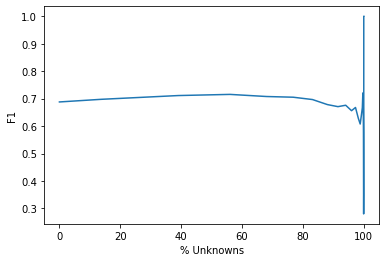

In [ ]:
#plots graph
thresh = np.linspace(-2, 3, 50)
x = [100*(1-sum(margin > t)/len(margin)) for t in thresh]
y = [f1_score(test["wine_variant"][margin > t], predicted[margin > t], average="macro") for t in thresh]
plt.plot(x, y)
plt.xlabel('% Unknowns')
plt.ylabel('F1')

## For Reuters texts, we found we could greatly increase the F1 score/accuracy by excluding items that that the model was most uncertain about. How many test examples would we have to exclude to achieve better than 0.85 F1 for this task?

Based on our graph it is not possible for us to acheive better than .85 F1 value for this. We can see that the F1 value remains fairly stagnant till we get to about 90%, which dips due to the decrease in the number of data points. 

In [ ]:
#imports to create a confusiong matrix
from sklearn.metrics import classification_report, f1_score, plot_confusion_matrix

In [ ]:
sgd

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_df=0.8, min_df=3,
                                 preprocessor=<cyfunction identity at 0x7fd2345842b0>,
                                 tokenizer=<function tokenize at 0x7fd1cba8ee50>)),
                ('tfidftransformer', TfidfTransformer()),
                ('sgdclassifier', SGDClassifier(alpha=1.558e-05))])

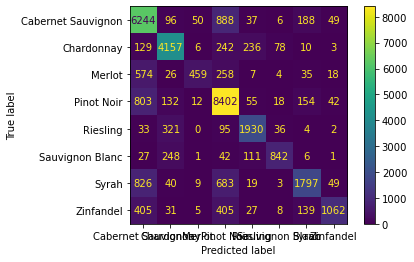

In [ ]:
#the plotting of our sgd confusion matrix
plot_confusion_matrix(sgd, test["review_text"], test["wine_variant"])

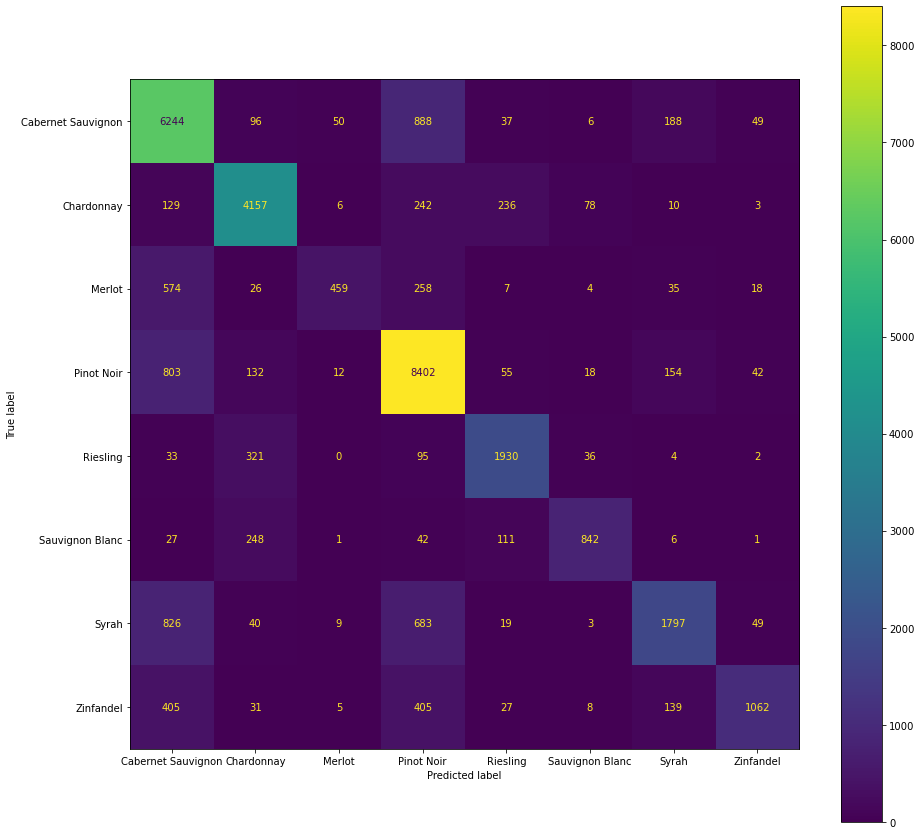

In [ ]:
#readjusting the size of our confusion matrix to have the x- axis be more visible. Noticed that Pinot Noir and Cabernet Sauvignon have high values it could be considered that there are similarities between the two
fig, ax = plt.subplots(figsize=(15,15))
plot_confusion_matrix(sgd, test['review_text'], test['wine_variant'], ax=ax)

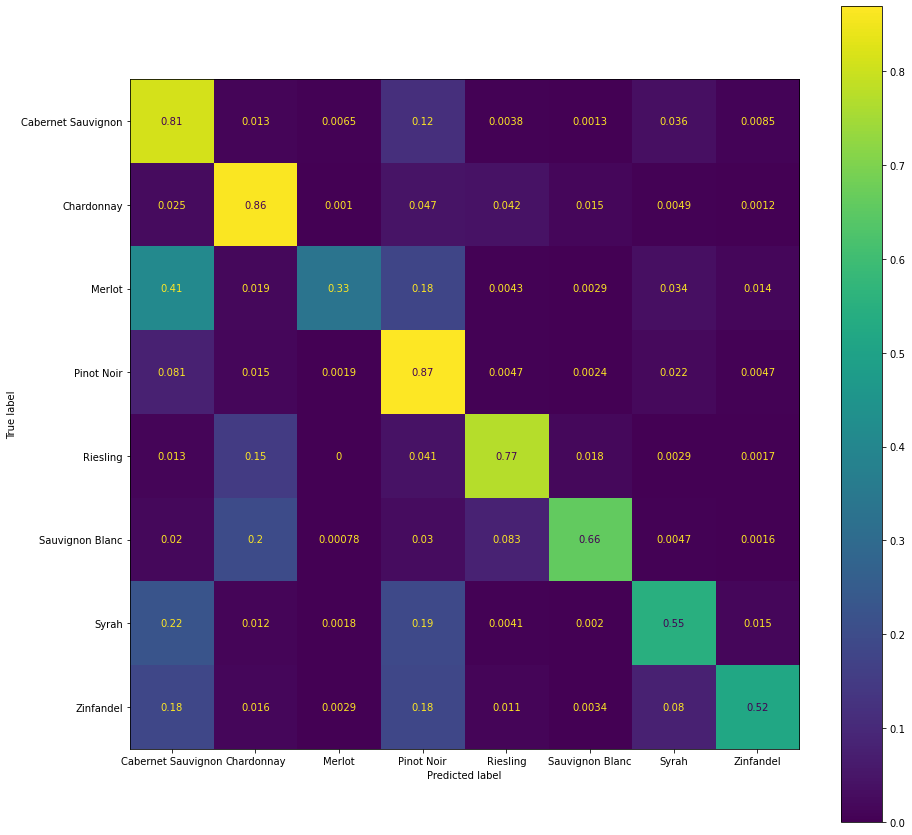

In [ ]:
fig, bx = plt.subplots(figsize=(15,15))
plot_confusion_matrix(sgd, test["review_text"], test["wine_variant"], normalize= 'true', ax = bx)
                      

In [ ]:
#creating copies of the original df
train_copy = train.copy()

In [ ]:
test_copy = test.copy()

In [ ]:
#defining 'm' for the wine variants i want to combine
m = train_copy['wine_variant'].isin(['Cabernet Sauvignon', 'Pinot Noir', 'Merlot'])

In [ ]:
#combining the wine variants of cabernet sauvignon and pinot noir to be combined
train_copy['wine_variant'] = train_copy['wine_variant'].mask(m, 'Cab S/Pinot n/ Merlot')

In [ ]:
train_copy["wine_variant"].value_counts()

Cab S/Pinot n/ Merlot    74227
Chardonnay               19443
Syrah                    13704
Riesling                  9683
Zinfandel                 8327
Sauvignon Blanc           5113
Name: wine_variant, dtype: int64

In [ ]:
d = test_copy['wine_variant'].isin(['Cabernet Sauvignon', 'Pinot Noir', 'Merlot'])

In [ ]:
test_copy['wine_variant'] = test_copy['wine_variant'].mask(d, 'Cab S/Pinot n/ Merlot')

In [ ]:
#establishing our baseline to determine a threshold to try to beat for our sgdclassifier
baseline = make_pipeline(CountVectorizer(analyzer=identity), SGDClassifier())
baseline.fit(train_copy["tokens"], train_copy["wine_variant"])
base_predicted = baseline.predict(test_copy["tokens"])
print(classification_report(test_copy["wine_variant"], base_predicted))

                       precision    recall  f1-score   support

Cab S/Pinot n/ Merlot       0.83      0.98      0.90     18557
           Chardonnay       0.86      0.82      0.84      4861
             Riesling       0.85      0.75      0.80      2421
      Sauvignon Blanc       0.89      0.62      0.73      1278
                Syrah       0.81      0.49      0.61      3426
            Zinfandel       0.92      0.49      0.64      2082

             accuracy                           0.84     32625
            macro avg       0.86      0.69      0.75     32625
         weighted avg       0.84      0.84      0.83     32625



## Another way to improve accuracy is to change the labels. Use a confusion matrix to examine the patterns errors and propose a new labeling scheme. For example, if the model consistently labels “merlot” as “riesling” and vice versa, you might want to create a new label “merlot/riesling”. Is it possible to get better than 0.85 F1 using your classifier trained on a different set of labels?


In this section I was able to increase my f1-score to .84 which is significantly higher than the initial, by combining three categories of wine I was able to increase the f-1 value. It would be possible to get better than .85 F1 using my classifier trained on a different set of lables, one way to do this would be to divide the reds and the white wines. This would make our model highly accurate, but the explanation of the model would then change. It would no longer identify specific types of wine it would identify the differences from red and white.